# Регрессия для SI

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing   import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline        import Pipeline
from sklearn.linear_model    import (
    LinearRegression,
    LassoCV,
    ElasticNetCV
)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from xgboost  import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [4]:
df_clean = pd.read_csv("df_cleaned.csv")
df_clean.head(5)

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,2,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_clean.shape

(980, 196)

In [6]:
X = df_clean.drop(['IC50, mM', 'SI', 'CC50, mM', 'Unnamed: 0'], axis=1)  
y = np.log1p(df_clean['SI'])

In [7]:
# Добавляем целевую переменную в DataFrame
X_with_target = X.copy()
X_with_target["target"] = y

# Вычисляем корреляционную матрицу
corr_matrix = X_with_target.corr(numeric_only=True)
target_corr = corr_matrix["target"].drop("target").sort_values(key=np.abs, ascending=False)

selected_cols = target_corr.head(10).index.tolist()

print("\nТоп-10 признаков по модулю корреляции с целевой переменной:")
print(target_corr.head(10))

# Генерация полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_with_target[selected_cols])
poly_feature_names = poly.get_feature_names_out(selected_cols)

df_poly = pd.DataFrame(X_poly, columns=poly_feature_names, index=X_with_target.index)

# Отбираем только новые признаки (исключаем исходные)
new_poly_features = [f for f in poly_feature_names if f not in selected_cols]
df_poly_new_only = df_poly[new_poly_features] 

# Добавляем целевую переменную
df_poly_with_target = df_poly_new_only.copy()
df_poly_with_target['target'] = y

# Вычисляем корреляцию с целевой переменной
corr_matrix = df_poly_with_target.corr(numeric_only=True)
corr_target = corr_matrix['target'].drop('target')

# Топ-20 новых признаков по модулю корреляции
top_20 = corr_target.abs().sort_values(ascending=False).head(20)

print("Топ-20 новых полиномиальных признаков по корреляции с целевой переменной:")
print(top_20)


Топ-10 признаков по модулю корреляции с целевой переменной:
FractionCSP3                0.222570
SMR_VSA7                   -0.217222
SlogP_VSA6                 -0.204120
NumAliphaticHeterocycles   -0.200126
RingCount                  -0.194138
NumSaturatedHeterocycles   -0.194086
fr_Imine                    0.192650
NumAromaticRings           -0.187033
VSA_EState6                -0.183866
fr_NH2                      0.182892
Name: target, dtype: float64
Топ-20 новых полиномиальных признаков по корреляции с целевой переменной:
FractionCSP3 fr_Imine                    0.218099
FractionCSP3^2                           0.210081
SMR_VSA7 SlogP_VSA6                      0.180224
SlogP_VSA6^2                             0.179367
FractionCSP3 NumAliphaticHeterocycles    0.175692
SlogP_VSA6 RingCount                     0.174778
SMR_VSA7^2                               0.174549
RingCount NumSaturatedHeterocycles       0.171587
SMR_VSA7 RingCount                       0.170295
FractionCSP3 fr_

In [8]:
# Добавляем отобранные признаки в основной датафрейм
top_20_poly_features = top_20.index.tolist()
df_extended = pd.concat([X, df_poly[top_20_poly_features]], axis=1)
print(f"Новый размер датафрейма: {df_extended.shape}")

Новый размер датафрейма: (980, 212)


In [9]:
# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_extended)

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42)

# Обучение Lasso с кросс-валидацией для автоматического выбора alpha
lasso = LassoCV(cv=5, random_state=42, max_iter=50_000, tol=1e-3)
lasso.fit(X_train, y_train)

# Выводим коэффициенты
coef = pd.Series(lasso.coef_, index=df_extended.columns)
print("Коэффициенты Lasso:")
print(coef)

# Отбор признаков: только те, у которых коэффициент ≠ 0
selector = SelectFromModel(lasso, prefit=True)
selected_features = df_extended.columns[selector.get_support()]
X_selected_df = pd.DataFrame(df_extended, columns=selected_features)

# Показать отобранные признаки
selected_features = df_extended.columns[selector.get_support()]
print("\nВыбранные признаки:")
print(selected_features.shape)

Коэффициенты Lasso:
MaxAbsEStateIndex                    -0.104565
MaxEStateIndex                       -0.000000
MinAbsEStateIndex                    -0.000000
MinEStateIndex                        0.025486
qed                                   0.000000
                                        ...   
SMR_VSA7 VSA_EState6                  0.000000
SMR_VSA7 NumAromaticRings             0.000000
NumAromaticRings VSA_EState6         -0.000000
NumAliphaticHeterocycles^2            0.000000
NumAliphaticHeterocycles RingCount    0.137653
Length: 212, dtype: float64

Выбранные признаки:
(86,)


(980, 86)


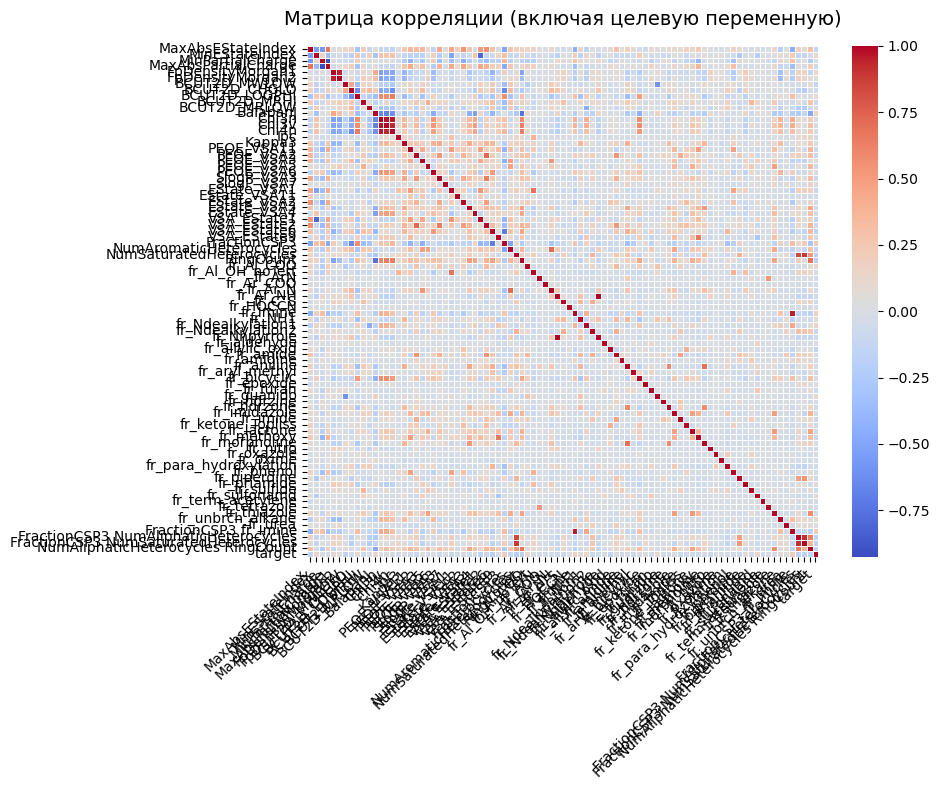


Топ-10 признаков по модулю корреляции с целевой переменной:
FractionCSP3                             0.222570
FractionCSP3 fr_Imine                    0.218099
RingCount                               -0.194138
NumSaturatedHeterocycles                -0.194086
fr_Imine                                 0.192650
VSA_EState6                             -0.183866
FractionCSP3 NumAliphaticHeterocycles   -0.175692
FractionCSP3 NumSaturatedHeterocycles   -0.167687
VSA_EState1                             -0.154724
MaxAbsEStateIndex                       -0.154275
Name: target, dtype: float64


In [10]:
X_selected_df = pd.DataFrame(df_extended, columns=selected_features)
# Создаем DataFrame из отобранных признаков
print(X_selected_df.shape)

# Добавляем целевую переменную в DataFrame
X_with_target = X_selected_df.copy()
X_with_target["target"] = y

# Вычисляем корреляционную матрицу
corr_matrix = X_with_target.corr(numeric_only=True)

# --- 1. Визуализация матрицы корреляций (включая target) ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    xticklabels=True,
    yticklabels=True
)
plt.xticks(rotation=45, ha='right')
plt.title('Матрица корреляции (включая целевую переменную)', fontsize=14, pad=15)
plt.tight_layout()
plt.show()

# Топ-10 признаков по корреляции с целевой переменной ---
target_corr = corr_matrix["target"].drop("target").sort_values(key=np.abs, ascending=False)

print("\nТоп-10 признаков по модулю корреляции с целевой переменной:")
print(target_corr.head(10))


In [11]:
base_models = {
    "LinearRegression": LinearRegression(),
    "RandomForest":     RandomForestRegressor(random_state=42),
    "ExtraTrees":       ExtraTreesRegressor(random_state=42),
    "HistGBR":          HistGradientBoostingRegressor(random_state=42),
    "XGBoost":          XGBRegressor(random_state=42, verbosity=0),
    "LightGBM":         LGBMRegressor(random_state=42),
    "CatBoost":         CatBoostRegressor(random_state=42, verbose=0)
}

# Оборачиваем каждую модель в Pipeline со StandardScaler
models = {
    name: Pipeline([
        ("scaler", StandardScaler()),
        ("model", mdl)
    ])
    for name, mdl in base_models.items()
}

# Кросс-валидация и сбор результатов
CV = KFold(n_splits=5, shuffle=True, random_state=42)
SCORER = make_scorer(r2_score)

results = {}
for name, pipe in models.items():
    print(f"Обучение {name}...")
    scores = cross_val_score(
        pipe,
        X_selected_df,   
        y,
        cv=CV,
        scoring=SCORER,
        n_jobs=-1,
    )
    results[name] = scores
    print(f"{name} R²: {scores.mean():.4f} ± {scores.std():.4f}")

results_df = pd.DataFrame(results, index=[f"Fold {i+1}" for i in range(5)]).T
print("\nСравнение моделей (R² по фолдам):")
display(results_df.sort_values(by="Fold 1", ascending=False))


Обучение LinearRegression...
LinearRegression R²: -196116717141866020864.0000 ± 392233434282825351168.0000
Обучение RandomForest...
RandomForest R²: 0.3162 ± 0.0660
Обучение ExtraTrees...
ExtraTrees R²: 0.2447 ± 0.0629
Обучение HistGBR...
HistGBR R²: 0.2650 ± 0.0714
Обучение XGBoost...
XGBoost R²: 0.2168 ± 0.0613
Обучение LightGBM...
LightGBM R²: 0.2583 ± 0.0759
Обучение CatBoost...
CatBoost R²: 0.2851 ± 0.0728

Сравнение моделей (R² по фолдам):


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RandomForest,0.431492,3.091235e-01,3.293938e-01,0.234802,0.276080
CatBoost,0.410170,2.552478e-01,3.128648e-01,0.194797,0.252349
HistGBR,0.372327,2.424645e-01,3.194406e-01,0.175112,0.215768
LightGBM,0.371936,2.666358e-01,3.019539e-01,0.185500,0.165317
ExtraTrees,0.347796,2.613208e-01,2.567369e-01,0.172928,0.184758
XGBoost,0.333878,1.882035e-01,2.197505e-01,0.177996,0.164281
LinearRegression,0.241276,-1.813434e+09,-9.805836e+20,-1.312437,0.226585


In [34]:
# CV и метрика
CV = KFold(n_splits=5, shuffle=True, random_state=42)
SCORER = make_scorer(r2_score)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_jobs": -1,
        "random_state": 42,
    }

    model = RandomForestRegressor(**params)

    scores = cross_val_score(
        model,
        X_selected_df, y,
        cv=CV,
        scoring=SCORER,
        n_jobs=-1,
    )
    return scores.mean()

# Запуск оптимизации
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600, show_progress_bar=True)

# Лучшие параметры и результат
print("Лучшие параметры:", study.best_params)
print("Лучшая R² на CV:", study.best_value)

best_model = RandomForestRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² на тесте: {r2:.4f}")

[I 2025-06-15 16:04:57,368] A new study created in memory with name: no-name-e50dc02f-ace9-466e-935f-d272c407eb68


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-15 16:05:01,055] Trial 0 finished with value: 0.08756472599722269 and parameters: {'n_estimators': 100, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.08756472599722269.
[I 2025-06-15 16:05:06,908] Trial 1 finished with value: 0.2879785443225528 and parameters: {'n_estimators': 2000, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.2879785443225528.
[I 2025-06-15 16:05:08,412] Trial 2 finished with value: 0.3006748675385488 and parameters: {'n_estimators': 700, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.3006748675385488.
[I 2025-06-15 16:05:11,866] Trial 3 finished with value: 0.29131324676623993 and parameters: {'n_estimators': 1500, 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 13, 'm

In [35]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

RMSE: 1.05
MAE : 0.83
R²  : 0.3831


C:\Users\belrs\anaconda3\envs\tf_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
